# Homework 02: Multi-Class Classification with Neural Networks

## Due: Midnight on September 14 (with 2-hour grace period) and worth 85 points

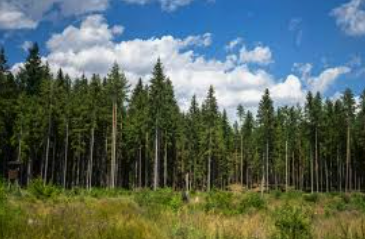

In this assignment, you’ll extend your Keras classification toolkit by training a neural network on a **balanced subset of the Forest Cover (Covertype) dataset**. We’ll begin with a simple baseline network, then study how performance changes as we vary **batch size**, **learning rate**, and apply a **cosine-decay schedule**.

For each configuration, you will consider a range of hyperparameter values, plot training/validation **loss** and **accuracy** over epochs, and determine which choice gave the best performance. 

Finally, you will consider all that you have learned and build your best model and run it on the test set. 


There are 9 graded questions, each worth 9 points, and you get 4 points for free if you complete the whole homework. 


In [1]:
# Useful imports

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_covtype

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecay

random_seed = 42

tf.random.set_seed(random_seed)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppresses INFO and WARNING messages

2025-09-13 07:45:25.047554: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Utility function: Plotting Training Loss (categorical x-entropy) and Accuracy

# Takes the history object returned by fit

def plot_history(history):
    n_epochs = len(history.history['accuracy'])
    epochs = range(1, n_epochs + 1)

    plt.figure(figsize=(7, 8))

    plt.subplot(2, 1, 1)
    plt.plot(epochs, history.history['loss'], label='Training Loss (Xent)', color='tab:red')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', color='tab:blue')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1.05)
    plt.title('Training Accuracy')
    plt.grid(True)
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

    final_loss = history.history['loss'][-1]
    final_acc = history.history['accuracy'][-1]
    print(f'Final Training Loss:     {final_loss:.4f}')
    print(f'Final Training Accuracy: {final_acc:.4f}')

## Load the dataset

The dataset is described in detail in the Appendix. For the purposes of this homework, we are selecting a random sample with 2747 samples in each class (to preserve balance), because the original dataset is both very large and very imbalanced, with the smallest class having 2747 samples. 

In [3]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter
import numpy as np

# Load
X, y = fetch_covtype(return_X_y=True)   # y in {1..7}
classes, counts = np.unique(y, return_counts=True)
min_count = counts.min()                # size of rarest class (~2.7k)

# Build perfectly balanced subset (no replacement, no duplicates)
rng = np.random.default_rng(42)
idx_list = []
for c in classes:
    c_idx = np.where(y == c)[0]
    chosen = rng.choice(c_idx, size=min_count, replace=False)
    idx_list.append(chosen)

idx_bal = np.concatenate(idx_list)
rng.shuffle(idx_bal)

X_sub = X[idx_bal]
y_sub = y[idx_bal] - 1                  # relabel to 0..6 for Keras
print("Subset shape:", X_sub.shape, "Class counts:", Counter(y_sub))


Subset shape: (19229, 54) Class counts: Counter({3: 2747, 2: 2747, 6: 2747, 5: 2747, 4: 2747, 1: 2747, 0: 2747})


## Problem One: Prepare the dataset and build a baseline model

### Part A: Stratified train/test split and standardization

As in Homework 1, follow these three steps:

1. **Stratified split:**
   Use `train_test_split` with `stratify=y_sub` to preserve class proportions in both training and test sets. Be sure to set `random_state=random_seed` and `test_size=0.2`.

2. **Standardize features:**
   Scale the input features so they have mean 0 and variance 1.



In [32]:
# Your code here
y_adjusted = y - 1

scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_adjusted,
    test_size=0.2,
    stratify=y_adjusted,
    random_state=random_seed
)




### Part B: Build, compile, train, and evaluate the network

1. **Build the model**

   * Use 2 hidden layers:  input &rarr; 64 &rarr; 32 &rarr; output.
   * Apply the `relu` activation for the hidden layers and `softmax` for the output layer.

2. **Compile the model**

    * Use the following parameters


           optimizer = Adam(learning_rate=0.0001),  
           loss = 'sparse_categorical_crossentropy',  
           metrics = ['accuracy']


4. **Train the model**

   * Run for **20 epochs**.
   * Use a `batch_size` of 32.

5. **Evaluate training**

   * Plot the training loss and accuracy curves using `plot_history`.

6. **Answer the graded questions**



Epoch 1/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.7150 - loss: 0.7001
Epoch 2/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.7534 - loss: 0.5777
Epoch 3/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.7671 - loss: 0.5462
Epoch 4/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.7761 - loss: 0.5255
Epoch 5/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 53s 4ms/step - accuracy: 0.7831 - loss: 0.5100
Epoch 6/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.7891 - loss: 0.4970
Epoch 7/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 92s 6ms/step - accuracy: 0.7946 - loss: 0.4859
Epoch 8/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.7997 - loss: 0.4763
Epoch 9/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 110s 8ms/step - accuracy: 0.8039 - loss: 0.4679
Epoch 10/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.8076 - loss: 0.4603
Epoch 11/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 73s 5ms/step - accuracy: 0.8112 - loss: 0.4

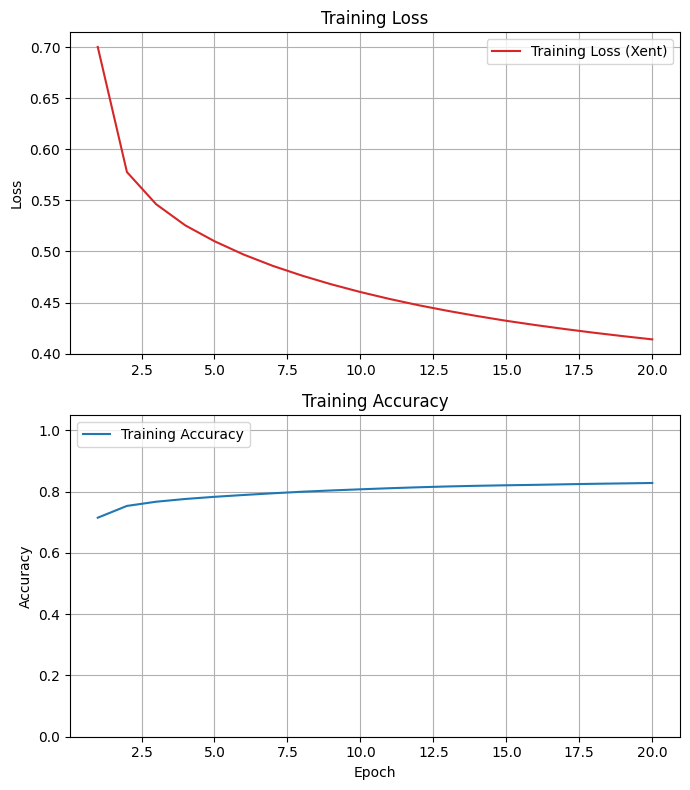

Final Training Loss:     0.4139
Final Training Accuracy: 0.8283


In [33]:
# Your code here

model = Sequential([
    Input(shape=(X_train.shape[1],)),     
    Dense(64, activation='relu'),         
    Dense(32, activation='relu'),         
    Dense(7, activation='softmax')        
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    verbose=1   
)

plot_history(history)


In [34]:
# Set a1a to the final training accuracy at epoch 20

a1a = 0.8283             # Replace 0.0 with your answer

In [35]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a1a = {a1a:.4f}')  

a1a = 0.8283


## Problem Two: Batch Sizes

Next, we’ll explore how the **batch size** affects training. .

* Start with the code from Problem One.
* Run **four experiments** using a batch size of 4, 8, 16, and 128, and  displaying the results using `plot_history`.

* Answer the graded questions.

**Note:** Consider using a `for` loop!


Training with batch size: 4
----------------------------------------
Results for batch size 4 (trained in 319.59 seconds):


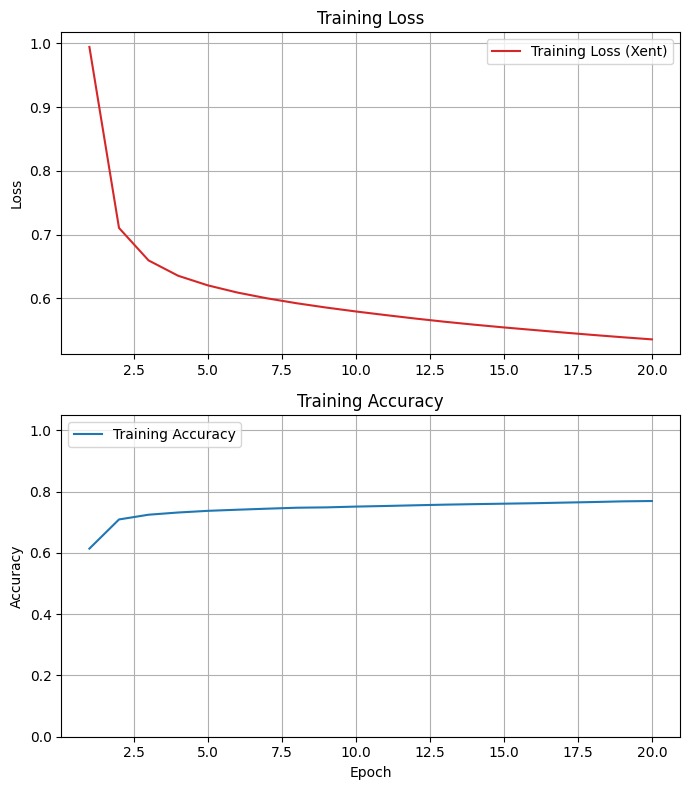

Final Training Loss:     0.5359
Final Training Accuracy: 0.7694

Training with batch size: 8
----------------------------------------
Results for batch size 8 (trained in 155.49 seconds):


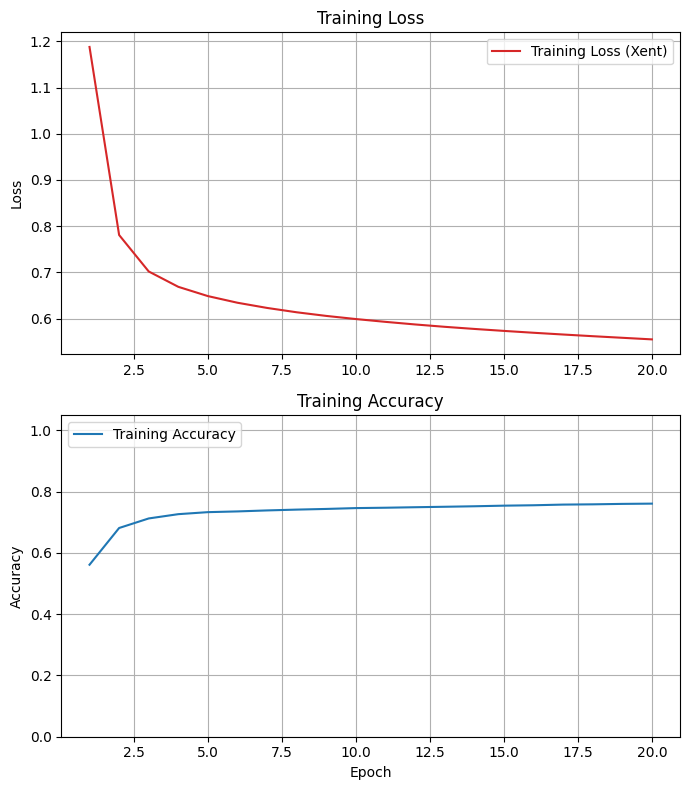

Final Training Loss:     0.5550
Final Training Accuracy: 0.7609

Training with batch size: 16
----------------------------------------
Results for batch size 16 (trained in 82.86 seconds):


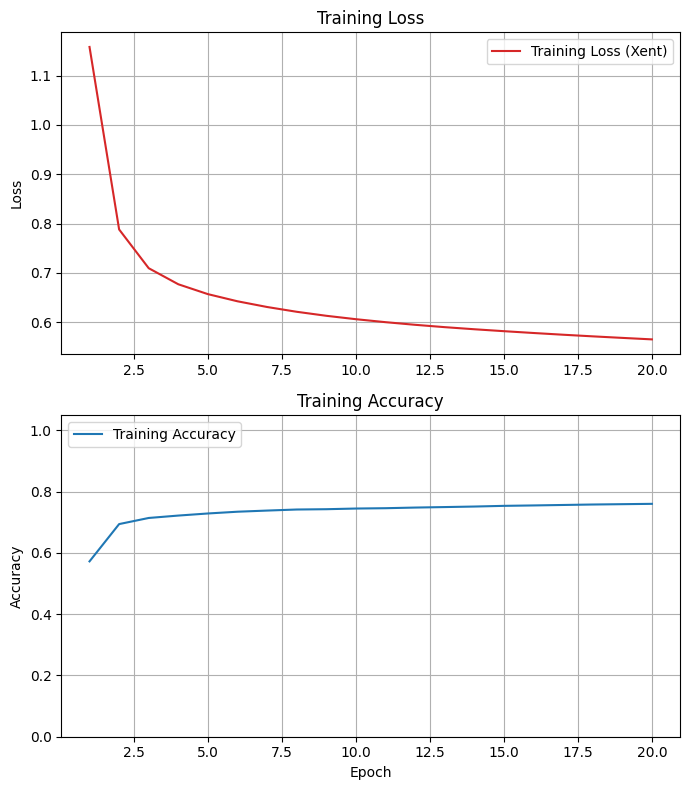

Final Training Loss:     0.5652
Final Training Accuracy: 0.7602

Training with batch size: 128
----------------------------------------
Results for batch size 128 (trained in 14.71 seconds):


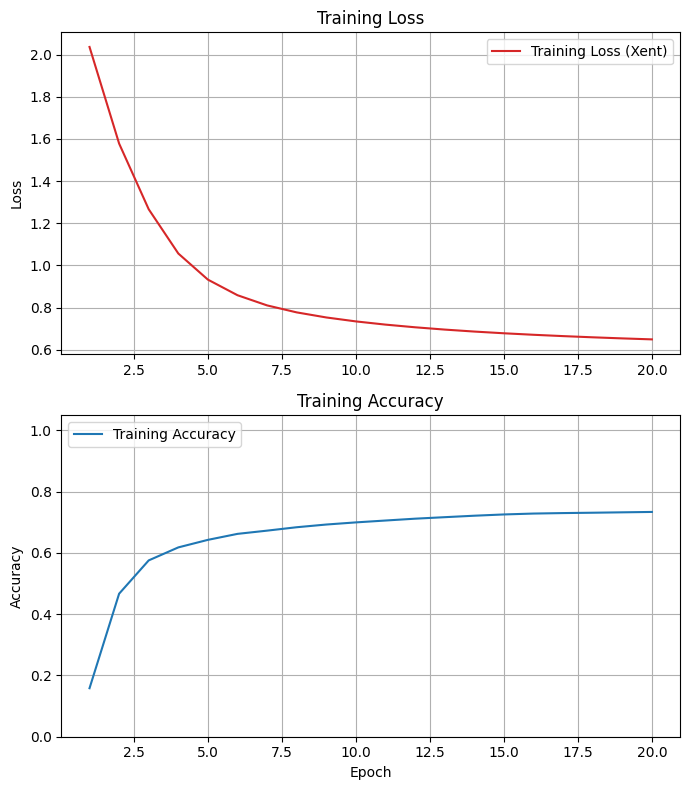

Final Training Loss:     0.6490
Final Training Accuracy: 0.7337


In [70]:
import time

#print training time for each batch to just be aware of the training time

batch_sizes = [4, 8, 16, 128]
epochs = 20

subset_size = 19173
X_small = X_train[:subset_size]
y_small = y_train[:subset_size]

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}\n{'-'*40}")
    
    model = Sequential([
        Input(shape=(X_small.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    history = model.fit(
        X_small, y_small,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    end_time = time.time()

    print(f"Results for batch size {batch_size} (trained in {end_time - start_time:.2f} seconds):")
    plot_history(history)



Training with batch size: 4
----------------------------------------
Results for batch size 4 (trained in 208.97 seconds):


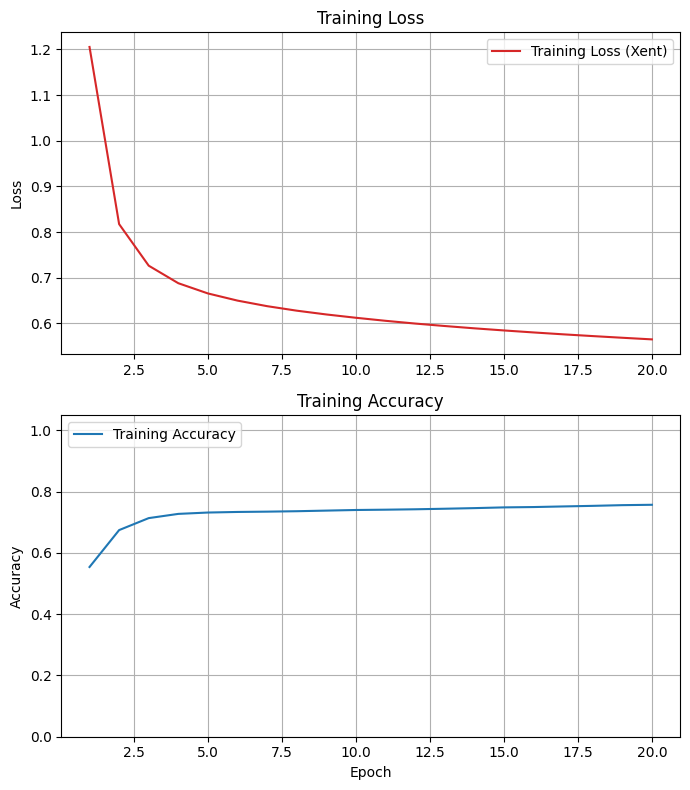

Final Training Loss:     0.5649
Final Training Accuracy: 0.7571

Training with batch size: 8
----------------------------------------
Results for batch size 8 (trained in 111.35 seconds):


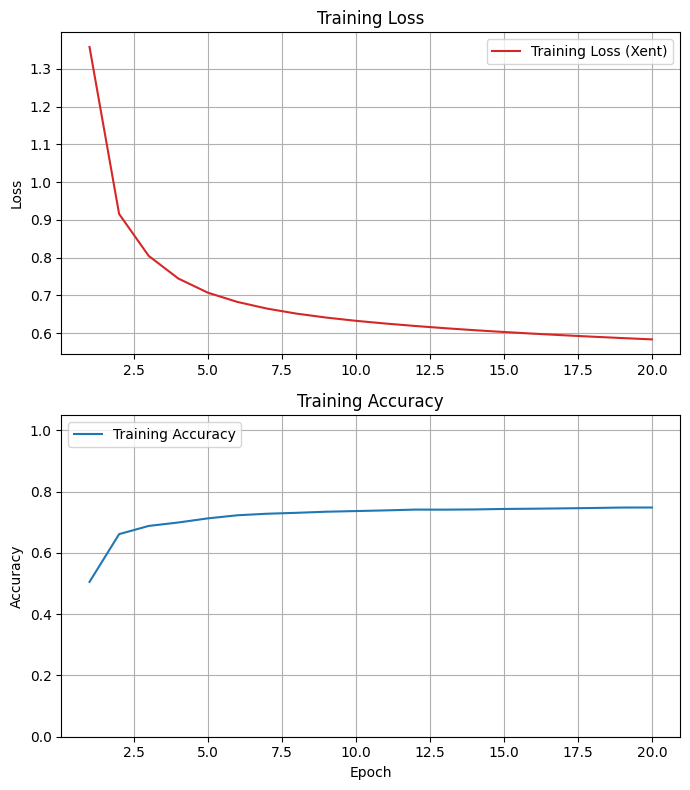

Final Training Loss:     0.5838
Final Training Accuracy: 0.7482

Training with batch size: 16
----------------------------------------
Results for batch size 16 (trained in 50.59 seconds):


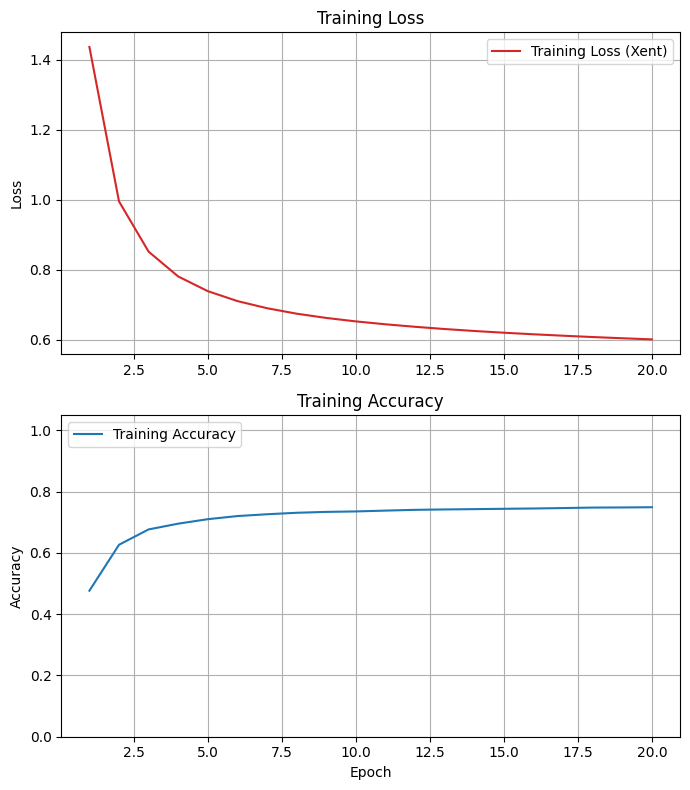

Final Training Loss:     0.6007
Final Training Accuracy: 0.7491

Training with batch size: 128
----------------------------------------
Results for batch size 128 (trained in 9.71 seconds):


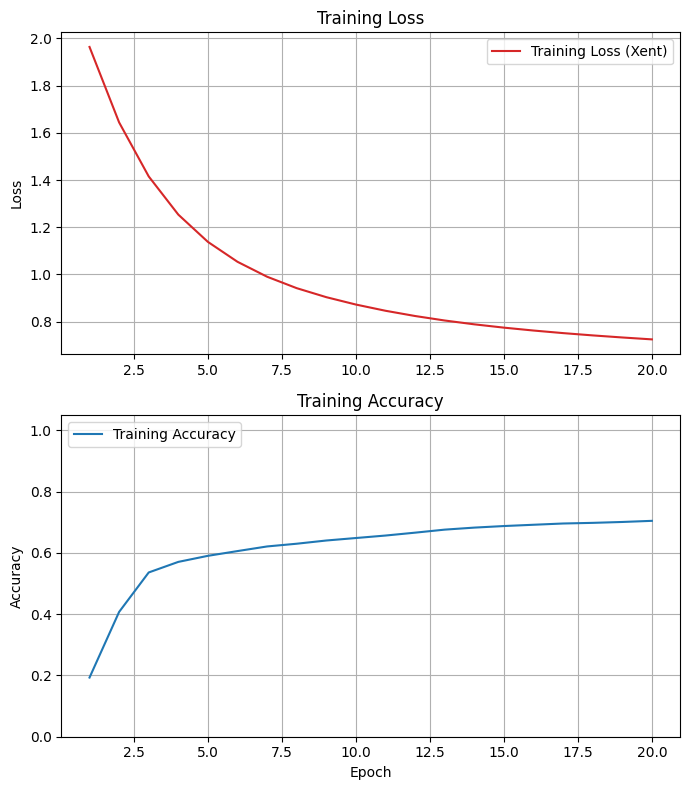

Final Training Loss:     0.7249
Final Training Accuracy: 0.7047


In [43]:
import time
#set to subset size of the x and y datasets because entire set takes more than 20 minutes
#subset is 10000 which is 50% of 19173 which is 3.3% of 581012
#print training time for each batch to just be aware of the training time
batch_sizes = [4, 8, 16, 128]
epochs = 20

subset_size = 10000
X_small = X_train[:subset_size]
y_small = y_train[:subset_size]

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}\n{'-'*40}")
    
    model = Sequential([
        Input(shape=(X_small.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    history = model.fit(
        X_small, y_small,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    end_time = time.time()

    print(f"Results for batch size {batch_size} (trained in {end_time - start_time:.2f} seconds):")
    plot_history(history)


In [44]:
# Set a2a to the batch size which produced the best accuracy score at epoch 20

a2a = 4             # Replace 0 with your answer

In [45]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2a = {a2a}') 

a2a = 4


In [46]:
# Set a2b to the best accuracy score found

a2b = 0.7571             # Replace 0.0 with your answer

In [47]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a2b = {a2b:.4f}') 

a2b = 0.7571


## Problem Three: Learning Rates

Next, we’ll explore how the **learning rate** affects training when using the Adam optimizer.

* Start with the code from **Problem One**.
* Add the `learning_rate` parameter to `Adam`.
* Run **five experiments** using the following values:

        [1e-3, 5e-4, 1e-4,5e-5, 1e-5]

* Display your results using `plot_history` and answer the graded questions.



Training with learning rate: 0.001
----------------------------------------
Results for learning rate 0.001 (trained in 29.53 sec):


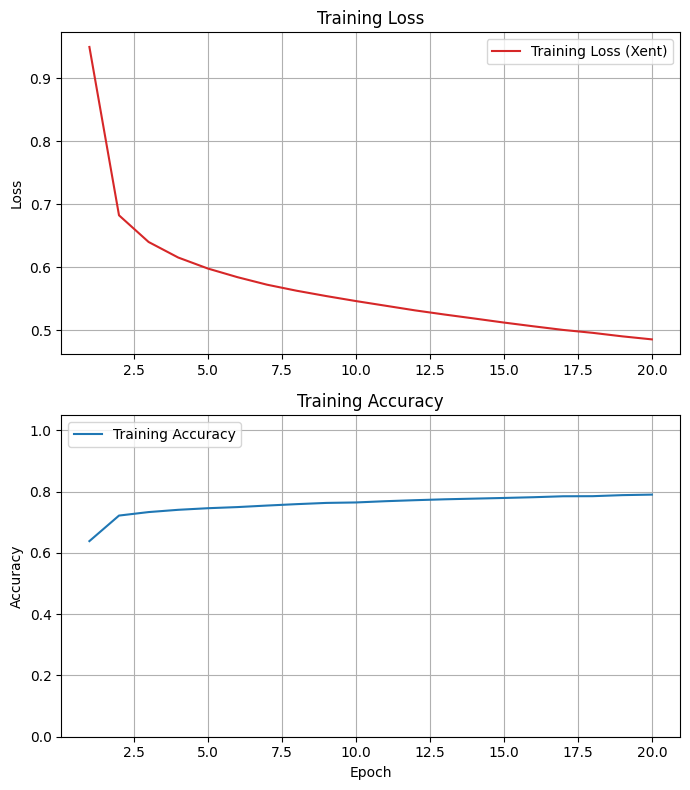

Final Training Loss:     0.4852
Final Training Accuracy: 0.7903

Training with learning rate: 0.0005
----------------------------------------
Results for learning rate 0.0005 (trained in 30.71 sec):


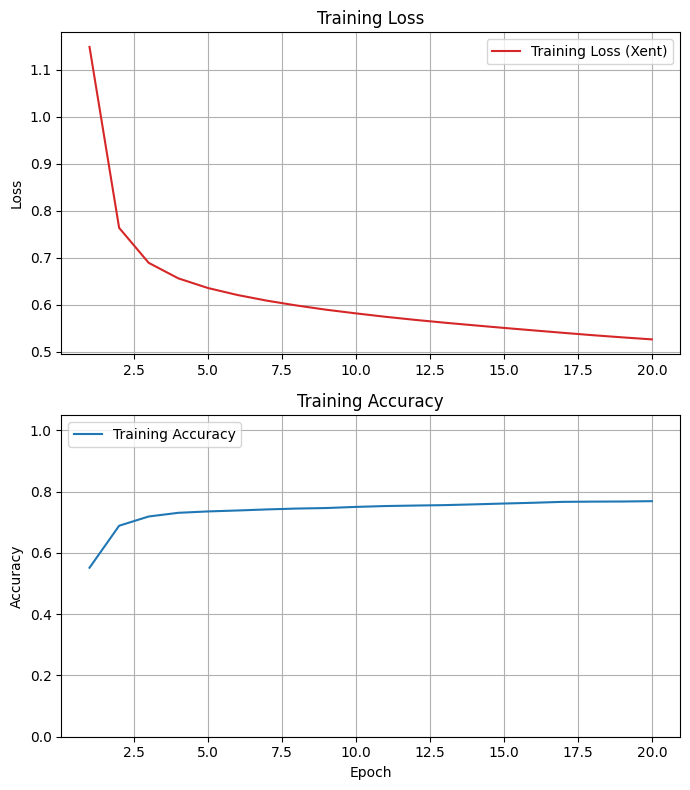

Final Training Loss:     0.5268
Final Training Accuracy: 0.7689

Training with learning rate: 0.0001
----------------------------------------
Results for learning rate 0.0001 (trained in 27.77 sec):


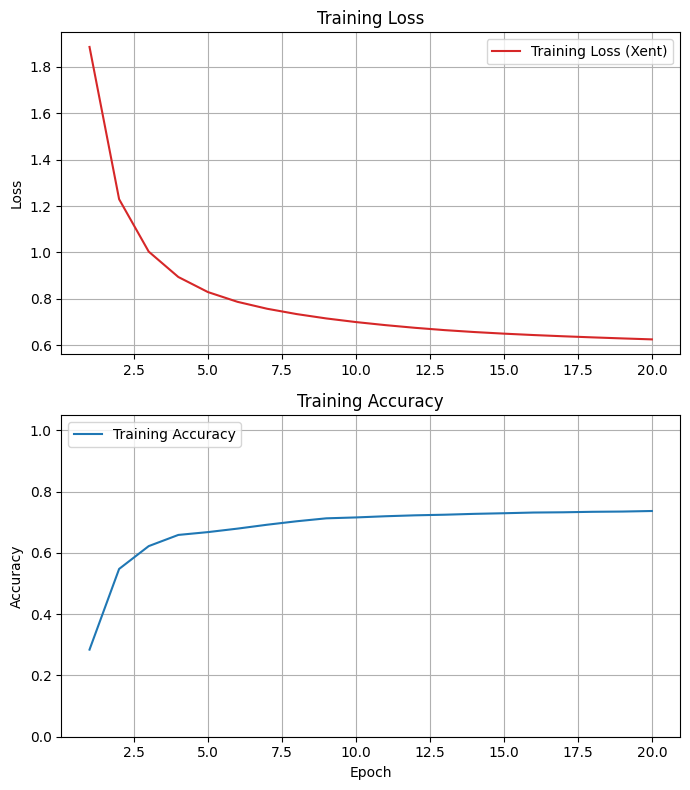

Final Training Loss:     0.6249
Final Training Accuracy: 0.7368

Training with learning rate: 5e-05
----------------------------------------
Results for learning rate 5e-05 (trained in 24.79 sec):


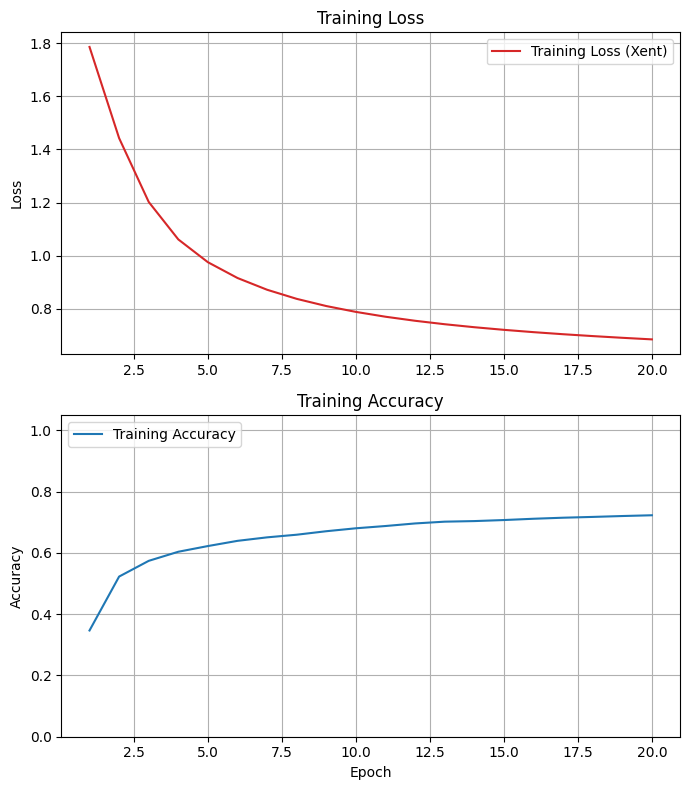

Final Training Loss:     0.6843
Final Training Accuracy: 0.7229

Training with learning rate: 1e-05
----------------------------------------
Results for learning rate 1e-05 (trained in 24.72 sec):


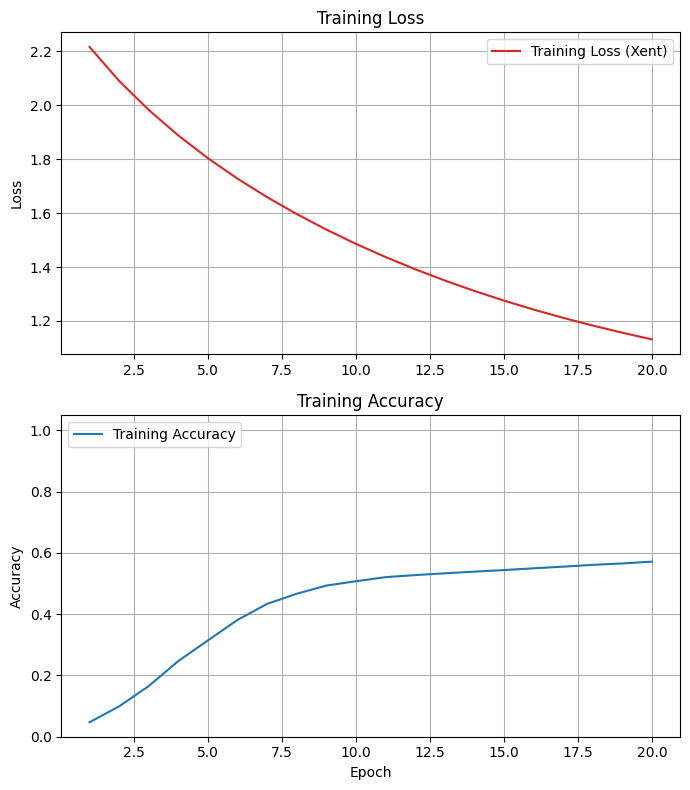

Final Training Loss:     1.1317
Final Training Accuracy: 0.5715


In [48]:
# Your code here

#set to subset size of the x and y datasets because my computer 
subset_size = 10000
X_small = X_train[:subset_size]
y_small = y_train[:subset_size]

learning_rates = [1e-3, 5e-4, 1e-4, 5e-5, 1e-5]
epochs = 20
batch_size = 32

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}\n{'-'*40}")
    
    model = Sequential([
        Input(shape=(X_small.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    history = model.fit(
        X_small, y_small,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    end_time = time.time()

    print(f"Results for learning rate {lr} (trained in {end_time - start_time:.2f} sec):")
    plot_history(history)


In [49]:
# Set a3a to the learning rate which produces the best (largest) accuracy at epoch 20

a3a = 1e-3             # Replace 0.0 with your answer

In [50]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3a = {a3a:.4f}') 

a3a = 0.0010


In [51]:
# Set a3b to the accuracy found by the best learning rate

a3b = 0.7903             # Replace 0.0 with your answer

In [52]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a3b = {a3b:.4f}') 

a3b = 0.7903


## Problem Four: Cosine Decay Learning Rate Scheduling

In this problem we'll gain some experience using the Cosine Decay learning rate scheduler with Adam. 

* Start with the code from **Problem One**.
* Define a `CosineDecay` learning rate scheduler (see `Week02_Coding.ipynb` for details)
* Use the scheduler with the Adam optimzier
* Run **five experiments** using the following values for `initial_learning_rate`:

        [1e-2, 5e-3, 1e-3,5e-4, 1e-4]

* Display your results using `plot_history` and answer the graded questions.


Training with CosineDecay LR, initial_learning_rate: 0.01
--------------------------------------------------
Results for initial LR 0.01 (trained in 27.14 sec):


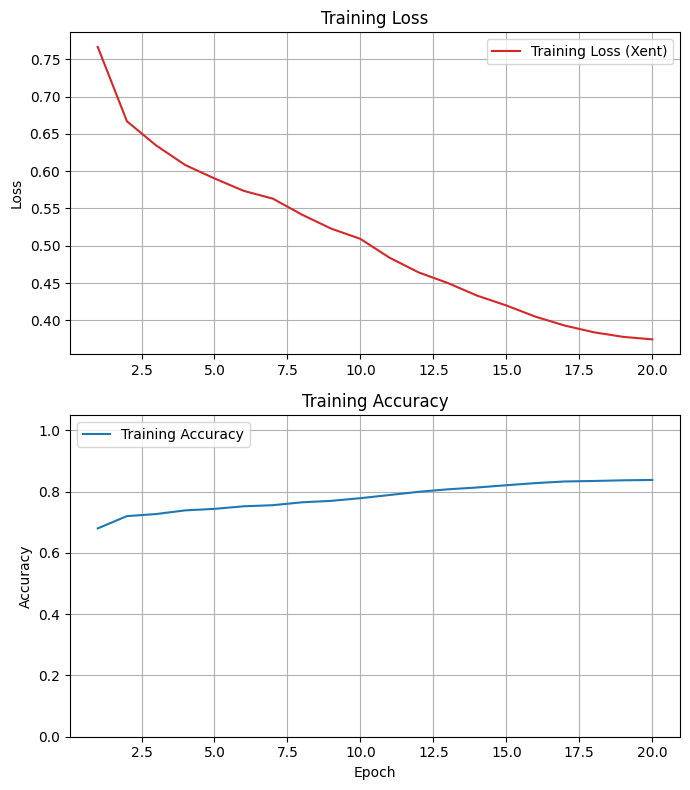

Final Training Loss:     0.3743
Final Training Accuracy: 0.8381

Training with CosineDecay LR, initial_learning_rate: 0.005
--------------------------------------------------
Results for initial LR 0.005 (trained in 18.59 sec):


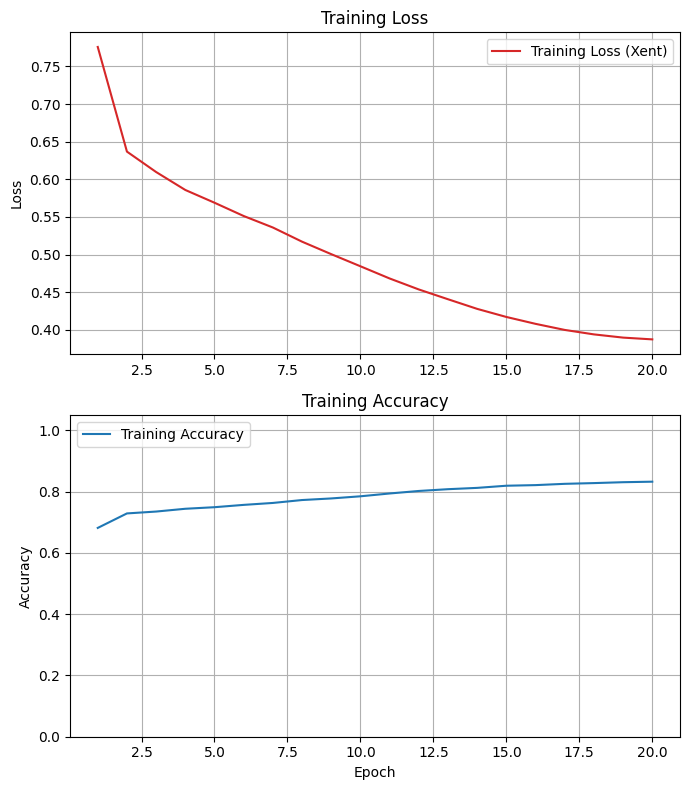

Final Training Loss:     0.3874
Final Training Accuracy: 0.8325

Training with CosineDecay LR, initial_learning_rate: 0.001
--------------------------------------------------
Results for initial LR 0.001 (trained in 24.61 sec):


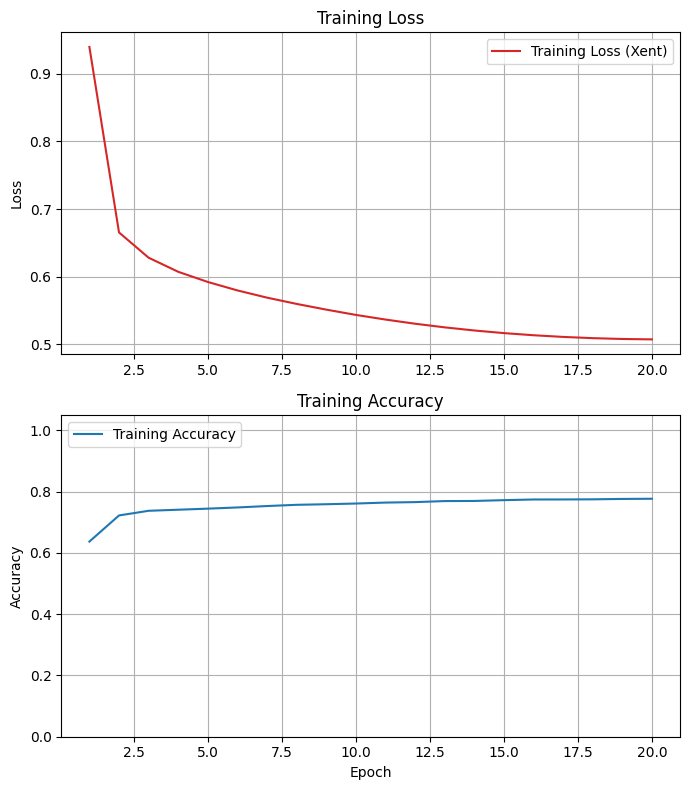

Final Training Loss:     0.5072
Final Training Accuracy: 0.7768

Training with CosineDecay LR, initial_learning_rate: 0.0005
--------------------------------------------------
Results for initial LR 0.0005 (trained in 18.99 sec):


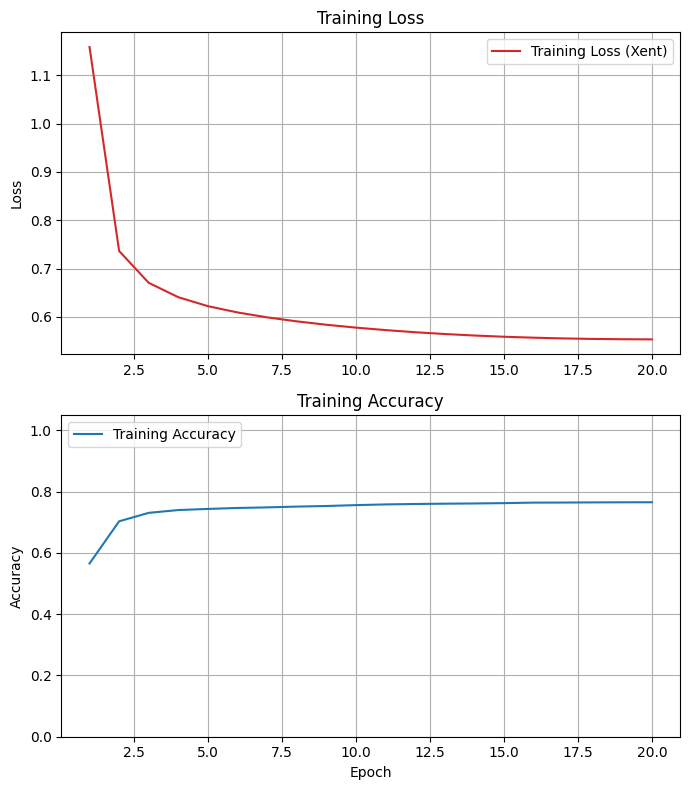

Final Training Loss:     0.5535
Final Training Accuracy: 0.7654

Training with CosineDecay LR, initial_learning_rate: 0.0001
--------------------------------------------------
Results for initial LR 0.0001 (trained in 20.54 sec):


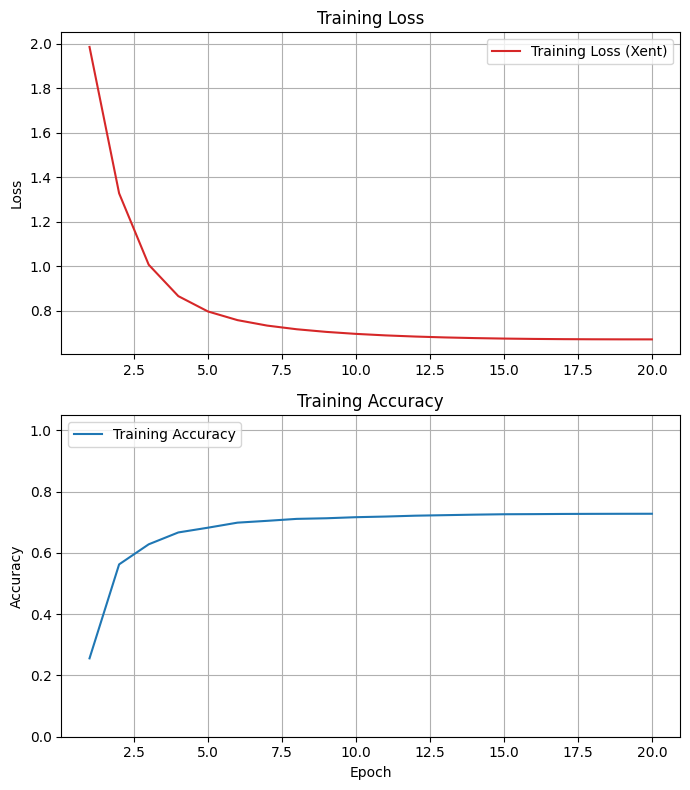

Final Training Loss:     0.6710
Final Training Accuracy: 0.7278


In [54]:
# Your code here

from tensorflow.keras.optimizers.schedules import CosineDecay


subset_size = 10000
X_small = X_train[:subset_size]
y_small = y_train[:subset_size]

initial_learning_rates = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
epochs = 20
batch_size = 32
steps_per_epoch = len(X_small) // batch_size
decay_steps = steps_per_epoch * epochs

for init_lr in initial_learning_rates:
    print(f"\nTraining with CosineDecay LR, initial_learning_rate: {init_lr}\n{'-'*50}")
    
    lr_schedule = CosineDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps,
        alpha=0.0  
    )

    model = Sequential([
        Input(shape=(X_small.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(7, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    start_time = time.time()
    history = model.fit(
        X_small, y_small,
        epochs=epochs,
        batch_size=batch_size,
        verbose=0
    )
    end_time = time.time()

    print(f"Results for initial LR {init_lr} (trained in {end_time - start_time:.2f} sec):")
    plot_history(history)



In [57]:
# Set a4a to the initial learning rate which produced the best accuracy

a4a = 1e-2             # Replace 0.0 with your answer

In [59]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4a = {a4a:.4f}') 

a4a = 0.0100


In [60]:
# Set a4b to the best accuracy found

a4b = 0.8381            # Replace 0.0 with your answer

In [61]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a4b = {a4b:.4f}') 

a4b = 0.8381


## Problem Five: Find the best model and run on the test set

In this final problem, you must consider all the experiments you've done and pick the
set of training hyperparameters which gives you the best accuracy after 20 epochs. Do not change the model architecture. 

Your choices are:

- Which batch size?
- Cosine Decay or constant learning rate?
    - If Cosine Decay, which initial learning rate?
    - If not, which constant learning rate?

* Display your results using `plot_history`
* Run your best model on the test set
* Answer the graded questions.


**OPTIONAL: change the model architecture (but use only dense layers) and try other learning rate schedulers (exponential, step, etc.)**

Epoch 1/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 56s 4ms/step - accuracy: 0.7660 - loss: 0.5510
Epoch 2/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.8095 - loss: 0.4514
Epoch 3/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.8258 - loss: 0.4149
Epoch 4/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.8353 - loss: 0.3923
Epoch 5/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.8427 - loss: 0.3768
Epoch 6/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 84s 4ms/step - accuracy: 0.8483 - loss: 0.3639
Epoch 7/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.8533 - loss: 0.3531
Epoch 8/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.8570 - loss: 0.3444
Epoch 9/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 63s 4ms/step - accuracy: 0.8607 - loss: 0.3366
Epoch 10/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 60s 4ms/step - accuracy: 0.8641 - loss: 0.3293
Epoch 11/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 39s 3ms/step - accuracy: 0.8675 - loss: 0.32

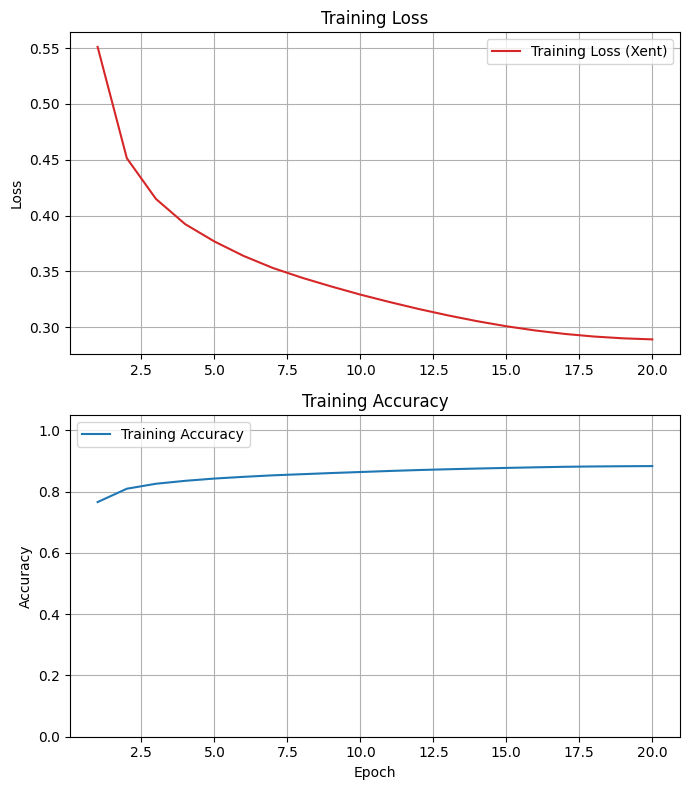

Final Training Loss:     0.2892
Final Training Accuracy: 0.8834

✅ Final Test Accuracy: 0.8786
❌ Final Test Loss: 0.3008


In [62]:
# Your code here -- add as many cells as you need
#base on above, batch_32 was the best
#base on above, cosine decay had more accuracy than constant learning rate
#base on above, 1e-2 is the best initial learning rate for training accuracy
#however, since we need to look at both trainin and testing accuracy data...
#let's try 1e-3 which is more generalize

from tensorflow.keras.optimizers.schedules import CosineDecay

epochs = 20
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
decay_steps = steps_per_epoch * epochs

best_lr_schedule = CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=decay_steps,
    alpha=0.0  
)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=best_lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

plot_history(history)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Final Test Accuracy: {test_accuracy:.4f}")
print(f"❌ Final Test Loss: {test_loss:.4f}")


Epoch 1/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.7558 - loss: 0.5752
Epoch 2/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 68s 5ms/step - accuracy: 0.7858 - loss: 0.5149
Epoch 3/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.7980 - loss: 0.4906
Epoch 4/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step - accuracy: 0.8056 - loss: 0.4757
Epoch 5/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 59s 4ms/step - accuracy: 0.8103 - loss: 0.4620
Epoch 6/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.8160 - loss: 0.4499
Epoch 7/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step - accuracy: 0.8213 - loss: 0.4382
Epoch 8/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 58s 4ms/step - accuracy: 0.8277 - loss: 0.4247
Epoch 9/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - accuracy: 0.8317 - loss: 0.4140
Epoch 10/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 52s 4ms/step - accuracy: 0.8370 - loss: 0.4008
Epoch 11/20
14526/14526 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.8420 - loss: 0.38

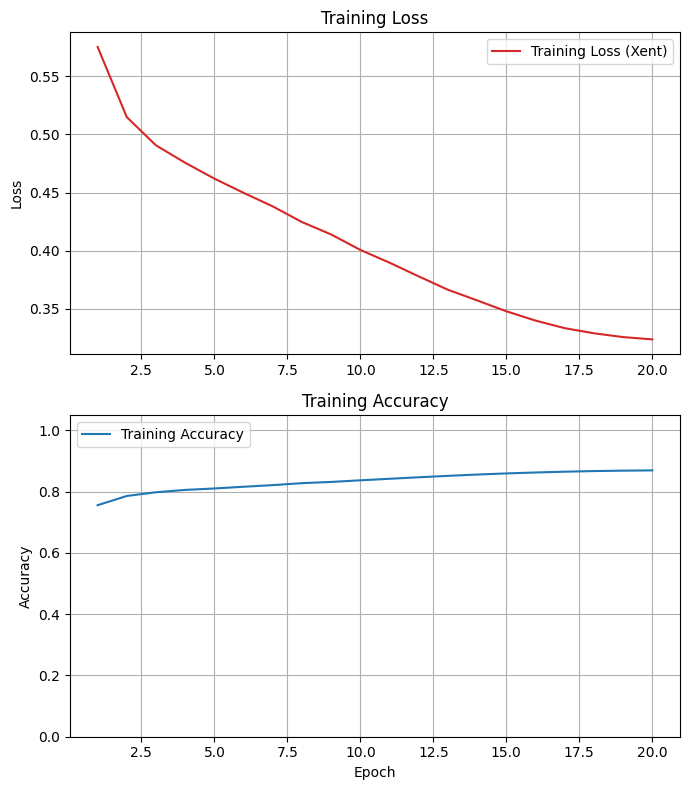

Final Training Loss:     0.3239
Final Training Accuracy: 0.8694

✅ Final Test Accuracy: 0.8653
❌ Final Test Loss: 0.3380


In [63]:
# Your code here -- add as many cells as you need
#base on above, batch_32 was the best
#base on above, cosine decay had more accuracy than constant learning rate
#base on above, 1e-2 is the best initial learning rate for training accuracy
#let's try 1e-2 this time

from tensorflow.keras.optimizers.schedules import CosineDecay

epochs = 20
batch_size = 32
steps_per_epoch = len(X_train) // batch_size
decay_steps = steps_per_epoch * epochs

best_lr_schedule = CosineDecay(
    initial_learning_rate=1e-2,
    decay_steps=decay_steps,
    alpha=0.0  
)

model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=best_lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

plot_history(history)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Accuracy: {test_accuracy:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")


Training with 1e-3 is better than 1e-2 so I will put accuracies based on 1e-3.

In [66]:
# Set a5a to the best training accuracy found by your best model

a5a = 0.8834             # Replace 0.0 with your answer

In [67]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5a = {a5a:.4f}') 

a5a = 0.8834


In [68]:
# Set a5b to the test accuracy found by your best model

a5b = 0.8786             # Replace 0.0 with your answer

In [69]:
# Graded Answer
# DO NOT change this cell in any way          

print(f'a5b = {a5b:.4f}') 

a5b = 0.8786


## Reflection Questions (ungraded)

1. We trained on a perfectly balanced \~3.3% subset.
   If we *increase the subset size* (still balanced), how would you expect (a) training time, (b) the best **batch size**, and (c) the best **learning rate** to change? Why?
Training time will definitely be longer, I did not create a subset to train originally and the first set of training already took more than 
2. **Batch size trade-offs.**
   With epochs fixed, why do smaller batches often generalize better on tabular data than large batches? What would you change if you *must* use a large batch?

3. **More epochs, same LR.**
    If you doubled the number of epochs (no other changes), what do you think would happen to train loss/acc and test acc? 

4. **Epochs vs. LR.**
   It is natural to think that there is an inverse relationship between the number of epochs and learning rate: if you move more slowly, it will take you longer to reach your goal. Does this seem true given what we have seen in the experiments with learning rate?

# Appendix:  Forest Cover Type (Covertype) — Dataset Overview

This dataset pairs **cartographic features** of 30×30 m land plots with the **dominant tree cover type**. Your task is to predict the cover type from terrain and soil indicators—an archetypal **multi-class classification** problem on tabular data.

**At a glance**

* **Samples:** 581,012 original; we’ll use a **balanced subset** (e.g., 2747 per class) for faster, fairer training.
* **Features (54 total):**

  * **10 continuous:** elevation, aspect, slope, distances to hydrology/roads/fire points, and hillshade at 9 AM/noon/3 PM.
  * **44 binary:** **4 Wilderness\_Area** flags and **40 Soil\_Type** one-hot indicators.
* **Target (7 classes):** Spruce/Fir, Lodgepole Pine, Ponderosa Pine, Cottonwood/Willow, Aspen, Douglas-fir, Krummholz.

**Why it’s useful here**

* Realistic, **tabular** data with mixed feature types.
* Clear demonstration of **scaling** (continuous features) vs. **binary indicators**.
* Originally **imbalanced**, which motivates mindful evaluation (we avoid this by using a balanced subset).


Shape: (19229, 55)

Class distribution:
 Cover_Type
3    0.142857
2    0.142857
6    0.142857
5    0.142857
4    0.142857
1    0.142857
0    0.142857
Name: proportion, dtype: float64


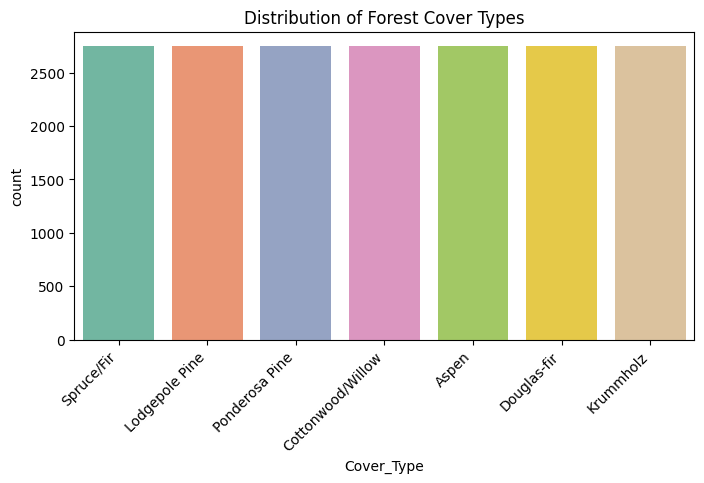

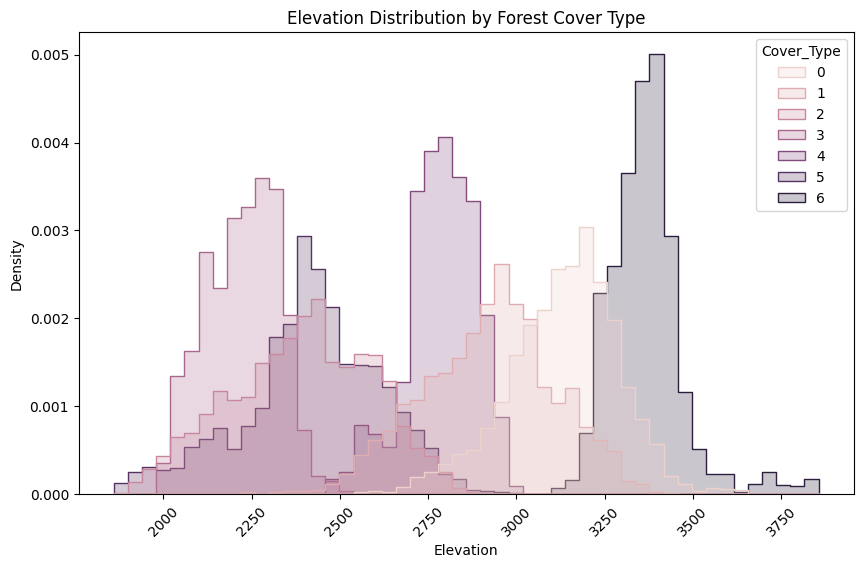

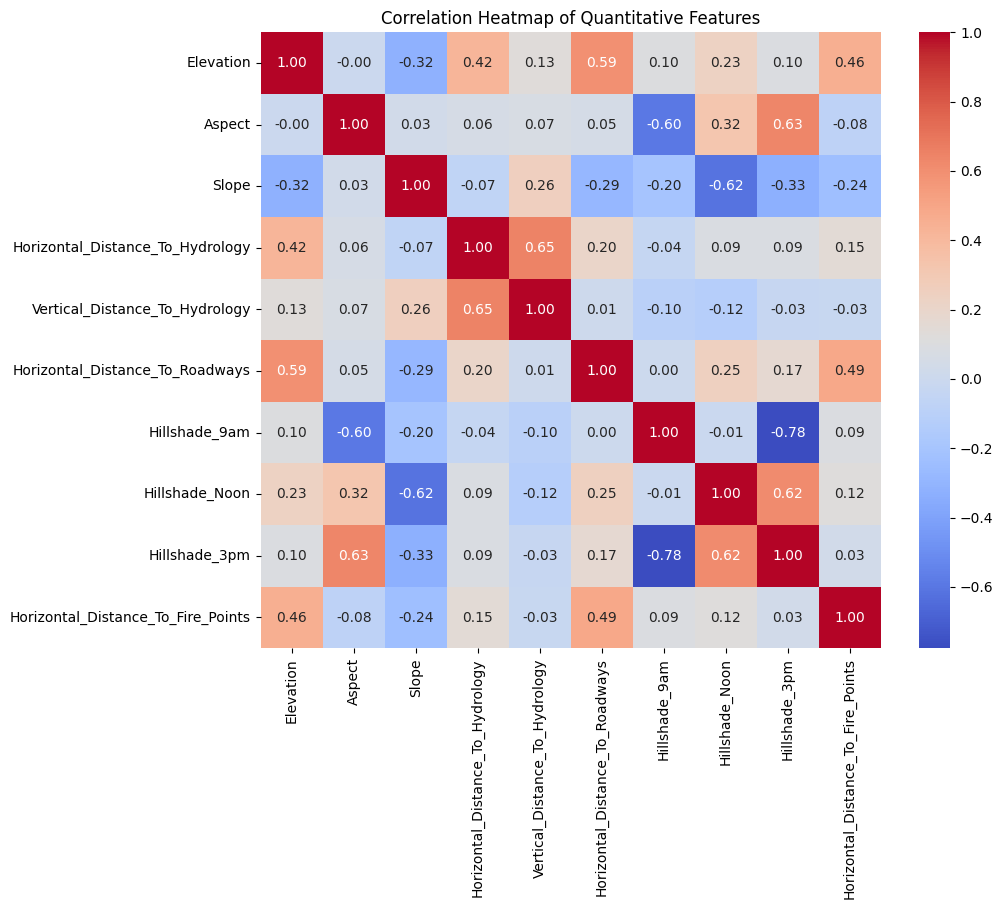

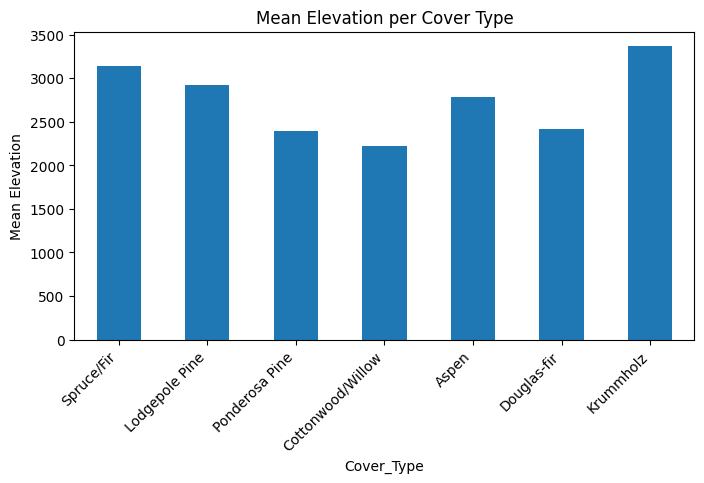

In [64]:
# Attach feature + class names
quant_features = [
    "Elevation", "Aspect", "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points"
]
wilderness_features = [f"Wilderness_Area{i}" for i in range(1, 5)]
soil_features = [f"Soil_Type{i}" for i in range(1, 41)]

feature_names = quant_features + wilderness_features + soil_features
class_names = [
    "Spruce/Fir", "Lodgepole Pine", "Ponderosa Pine",
    "Cottonwood/Willow", "Aspen", "Douglas-fir", "Krummholz"
]

# Create dataframe from your subset
df = pd.DataFrame(X_sub, columns=feature_names)
df["Cover_Type"] = y_sub

# 1. Basic info
print("Shape:", df.shape)
print("\nClass distribution:\n", df["Cover_Type"].value_counts(normalize=True))

# 2. Class distribution plot
plt.figure(figsize=(8,4))
sns.countplot(x="Cover_Type", hue="Cover_Type", data=df, palette="Set2", legend=False)
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.title("Distribution of Forest Cover Types")
plt.show()

# 3. Elevation distribution by class
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="Elevation", hue="Cover_Type",
             bins=50, element="step", stat="density", common_norm=False)
plt.xticks(rotation=45)
plt.title("Elevation Distribution by Forest Cover Type")
plt.show()

# 4. Correlation heatmap (quantitative features only)
plt.figure(figsize=(10,8))
corr = df[quant_features].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Quantitative Features")
plt.show()

# 5. Mean elevation per cover type
df.groupby("Cover_Type")["Elevation"].mean().plot(kind="bar", figsize=(8,4))
plt.xticks(ticks=range(7), labels=class_names, rotation=45, ha="right")
plt.ylabel("Mean Elevation")
plt.title("Mean Elevation per Cover Type")
plt.show()
